# Fairness in Healthcare

Many of the healthcare outcomes we try to predict are rare (sometimes less than .1% of observations), and even more rare in minority groups,due to issues ranging from social determinants of health, healthcare disparities, and many more. Because of this we shift focus on reducing harm and in this case want to reduce the number of false negatives or misdiagnosis in our models.

This is more true in the American healthcare system where healthcare resources are strained, so healthcare overall is triaging and not expanding fast enough to accomodate growing needs. Models such as those below are tools used to help triage and prioritize growing needs, increasing their influence in decision making within healthcare.

The types of harm I will focus on are allocation harms and quality of service harms. Underdiagnosing could potentially lead to worse healthcare outcomes and resources not provided by programs such as care management. We will  see this across our sensitive feature of interest.

# Data

The data we use for this example use based on the Glioma Grading data set provided by the National Cancer Institute (NCI) and found in UC Irvines Machine Learning Repository. This classification dataset determines whether a patient tumor is lower grade glioma (0) or glioblastoma multiforme (1) or aggressive form of tumor found in the brain and is supported by 23 features primarily focused on mutations. This sensitive feature we will use from this data set is the Race category.

# feature engineering

Lets begin by loading our data.

In [ ]:
from ucimlrepo import fetch_ucirepo

glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 
  
# variable information 
print(glioma_grading_clinical_and_mutation_features.variables) 


                name     role         type demographic  \
0              Grade   Target  Categorical        None   
1             Gender  Feature  Categorical      Gender   
2   Age_at_diagnosis  Feature   Continuous         Age   
3               Race  Feature  Categorical        Race   
4               IDH1  Feature  Categorical        None   
5               TP53  Feature  Categorical        None   
6               ATRX  Feature  Categorical        None   
7               PTEN  Feature  Categorical        None   
8               EGFR  Feature  Categorical        None   
9                CIC  Feature  Categorical        None   
10             MUC16  Feature  Categorical        None   
11            PIK3CA  Feature  Categorical        None   
12               NF1  Feature  Categorical        None   
13            PIK3R1  Feature  Categorical        None   
14             FUBP1  Feature  Categorical        None   
15               RB1  Feature  Categorical        None   
16            

In [2]:
import altair as alt

df = pd.concat([X,y], axis=1)

alt.Chart(df).mark_bar().encode(
    x='count()',
    y='Race:N',
    color = 'Grade:N'
).properties(
    width=600,
    height=250
)

alt.Chart(...)

With too few minority observations I have decided to combine them. This highlights many of the common data issues, or lack of data we see within minority groups. 

In [3]:
X['Race'] = np.where(X['Race'].isin(['white']), X['Race'], 'minority')

X

C:\Users\marti\AppData\Local\Temp\ipykernel_12240\895307715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Race'] = np.where(X['Race'].isin(['white']), X['Race'], 'minority')


,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,51.30,white,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,38.72,white,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,35.17,white,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,32.78,white,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,31.51,white,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,1,77.89,white,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835,0,85.18,white,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
836,1,77.49,white,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
837,0,63.33,white,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


Before we begin doing any transformations it is very important that you split data. We will create a train test split. 

Train will include our validation set and used via cross validation. This is recommended for data sets < 20,000.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print(f"training set size : {len(X_train)} \ntest set size: {len(X_test)}")


training set size : 671 
test set size: 168


# data prep pipeline

## scaling

To do our transformations we will leverage the Scikit-Learns estimators. We start by scaling using min-max scaling, normalization, from 0 to 1.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("scale", MinMaxScaler(feature_range=(0,1))),
])


## one hot encoding

Race is a categorical column and needs to be transformed into numeric.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder  

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder())
])


## Putting it all together

In [7]:
from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include=['float64'])),
    ("cat", cat_pipeline, make_column_selector(dtype_include=['object'])),
    ("binary", "passthrough", make_column_selector(dtype_include=['int64']))
])


# xgboost

One of my favorite packages which I have the most experience with is Xgboost. I will be using the scitkit learn estimator interface to coincide with the scikit learn data prep pipeline. This is my current favorite version. Other versions to test include the base xgboost, pyspark API, Dask, Ray, R, a recently revamped Sparklyr versions, some with there own nuances, but this and the base version are my favorites so far. Before assigning our predictor to our machine learning pipeline lets we do some light hyperparameter tuning with the more influential parameters.

In [8]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

tuning_pipeline = Pipeline([
    ("prep_data", preprocessing),
    ("xgboost", xgb.XGBClassifier(objective= "binary:logistic"
                                  , tree_method = "hist"
                                  , random_state = 42))
])

Simple grid using the more influential hyperparameters.

In [9]:
param_grid = [
    {'xgboost__learning_rate': [.01, .1, .3, .5],
     'xgboost__max_depth': [4, 6, 8, 10]}
]

Great thing about using this approach is once best hyperparameters are identified the model is trained on the entire dataset.

In [10]:
from sklearn.metrics import accuracy_score, recall_score

grid_search = GridSearchCV(estimator = tuning_pipeline
                           ,param_grid = param_grid
                           , cv=5
                           ,scoring='recall'
                           ,refit=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep_data',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABFFA2A770>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid=[{'xgboost__learning_rate': [0.01, 0.1, 0.3, 0.5],
                          'xgboost__max_depth': [4, 6, 8, 10]}],
             scoring='recall')

Best hyperparameters are identified:

* learning rate / eta .01
* max depth 4

In [11]:
grid_search.best_params_

{'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 4}

In [12]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgboost__learning_rate,param_xgboost__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040703,0.019436,0.008801,0.000401,0.01,4,"{'xgboost__learning_rate': 0.01, 'xgboost__max...",0.927273,0.944444,0.907407,0.909091,0.927273,0.923098,0.013660,1
1,0.044488,0.002492,0.009300,0.000597,0.01,6,"{'xgboost__learning_rate': 0.01, 'xgboost__max...",0.890909,0.851852,0.851852,0.872727,0.872727,0.868013,0.014772,2
4,0.030803,0.000929,0.008800,0.000748,0.1,4,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",0.890909,0.870370,0.814815,0.890909,0.872727,0.867946,0.027951,3
6,0.043874,0.001611,0.009101,0.000663,0.1,8,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",0.890909,0.796296,0.833333,0.872727,0.800000,0.838653,0.037969,4
5,0.036291,0.001093,0.009101,0.000799,0.1,6,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",0.890909,0.777778,0.814815,0.872727,0.836364,0.838519,0.040425,5


Now that we have the best hyperparameters lets fit these to our predictor and apply it to our pipeline.

In [13]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective = "binary:logistic"
                            , learning_rate = grid_search.best_params_['xgboost__learning_rate']
                            , max_depth = grid_search.best_params_['xgboost__max_depth']
                            , tree_method = "hist"
                            , random_state  = 42
    )
                        

In [14]:
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline([
    ("prep_data", preprocessing),
    ("xgboost", xgb_clf)
])

Overall accuracy is 86% but that may be representative of the accuracy overall in identifying lower grade glioma (0).

In [15]:
from sklearn.metrics import classification_report

xgb_pipeline.fit(X_train,y_train)
print(classification_report(y_test,xgb_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        89
           1       0.81      0.91      0.86        79

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.86      0.86      0.86       168



Recall for our outcome of interest is .91. Which sounds great! This means that we are able to identify 91% of actual positive cases. On the opposite side, we have a smaller likelihood of false negative prediction.

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

preds = xgb_pipeline.predict(X_test)

recall_metric = recall_score(y_test, preds)

recall_metric

0.9113924050632911

# Fairlearn: Assessments

The Fairlearn package can be broken into two components, assessments followed by mitigation. We will use the _MetricFrame_ function to identify differences in model metrics. This function is a great way to quickly quantify potential harm across different groups. This is a process we have previously only done by calculate these values manually.


In [17]:
preds = xgb_pipeline.predict(X_test)
preds.shape

(168,)

Recall for our model overall is high. 

In [18]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count
from sklearn.metrics import recall_score, accuracy_score, balanced_accuracy_score

my_metrics = {
    'recall' : recall_score,
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'count' : count
}

mf = MetricFrame(
    metrics = my_metrics,
    y_true = y_test,
    y_pred = preds, 
    sensitive_features = X_test['Race']
)


mf.overall

recall                 0.911392
accuracy               0.857143
balanced_accuracy      0.860191
count                168.000000
dtype: float64

However when we calculate recall by our sensitive feature there is a moderate difference. A potential sign of fairness harm.

In [19]:
mf.by_group

,recall,accuracy,balanced_accuracy,count
Race,,,,
minority,0.818182,0.722222,0.694805,18.0
white,0.926471,0.873333,0.877869,150.0


This calculates the larges difference between our groups, because we only have two categories its the difference in recall for minority and white.

In [20]:
mf.difference(method='between_groups')

recall                 0.108289
accuracy               0.151111
balanced_accuracy      0.183064
count                132.000000
dtype: float64

array([[<Axes: title={'center': 'recall'}, xlabel='Race'>,
        <Axes: title={'center': 'accuracy'}, xlabel='Race'>],
       [<Axes: title={'center': 'balanced_accuracy'}, xlabel='Race'>,
        <Axes: title={'center': 'count'}, xlabel='Race'>]], dtype=object)

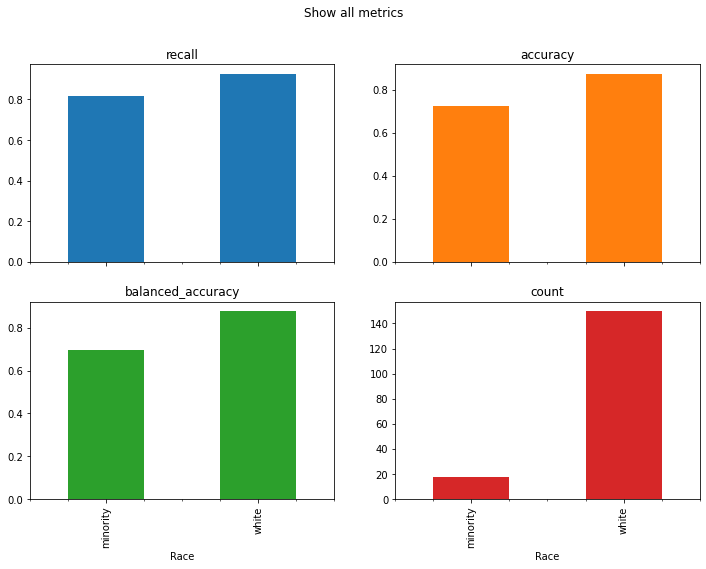

In [28]:
mf.by_group.plot.bar(
    subplots=True,
    layout=[2, 2],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Fairlearn: Mitigation

Fairlearn also provides various ways to address fairness. The approach we select is the postprocessing with thresholding. It works perfectly for our classification problem.

This approach test various thresholds that determine assignment to positive or negative cases based on our model scores or probabilities. This approach focuses on our metric,recall, of interest for our sensitive groups while also observing overall model performance. 

As a result a threshold is assigned to each of our sensitive features that maximizes both objective and constraints. This is illustrated easily with a Threshold optimizer for equalized odds that try to balance true and false positive rates. We use an ROC curve as a tradeoff curve by testing various thresholds along the curve.

In [21]:
from fairlearn.postprocessing import ThresholdOptimizer

threshold_optimizer = ThresholdOptimizer(
    estimator=xgb_pipeline,
    constraints="true_positive_rate_parity", # recall
    objective="accuracy_score", 
    predict_method="predict_proba", 
    prefit=False,
)

threshold_optimizer.fit(X_train, y_train, sensitive_features=X_train['Race'])

ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=Pipeline(steps=[('prep_data',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scale',
                                                                                                MinMaxScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001ABFFA2A770>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder())]),
                                                                               <sklearn.compose._column_transfo...
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                                            learning_rate=0.01,
                                                            max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=4,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   predict_method='predict_proba')

In [22]:
threshold_rules_by_group = threshold_optimizer.interpolated_thresholder_.interpolation_dict
threshold_rules_by_group

{'minority': {'p0': 0.737499999999999,
  'operation0': [>0.4500546157360077],
  'p1': 0.26250000000000095,
  'operation1': [>0.28922609984874725]},
 'white': {'p0': 0.0,
  'operation0': [>0.589908093214035],
  'p1': 1.0,
  'operation1': [>0.5382746458053589]}}

All potential thresholds for classifying an aggresive tumor are tested to maximize both accuracy and recall.

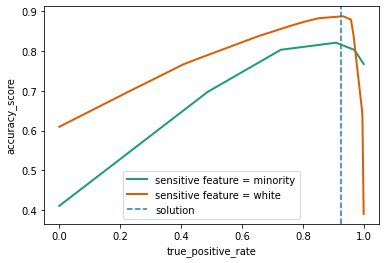

In [23]:
from fairlearn.postprocessing import plot_threshold_optimizer

plot_threshold_optimizer(threshold_optimizer)

Generate new predictions based on our thresholds.

In [24]:
thresh_preds = threshold_optimizer.predict(X_test, sensitive_features=X_test['Race'], random_state=12345)

thresh_preds

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.     0.2625 1.     1.     1.     0.2625 1.     0.     1.     1.
 1.     1.     1.     0.2625 0.     1.     1.     1.    ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

Lets evaluate our metrics once more.

In [25]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, selection_rate
from sklearn.metrics import recall_score, accuracy_score, balanced_accuracy_score

my_metrics = {
    'recall' : recall_score,
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'count' : count
}

mft = MetricFrame(
    metrics = my_metrics,
    y_true = y_test,
    y_pred = thresh_preds, 
    sensitive_features = X_test['Race']
)


mft.overall

recall                 0.911392
accuracy               0.857143
balanced_accuracy      0.860191
count                168.000000
dtype: float64

Final results, we see a increase in recall for the minority class. 

In [26]:
mft.by_group

,recall,accuracy,balanced_accuracy,count
Race,,,,
minority,0.909091,0.777778,0.740260,18.0
white,0.911765,0.866667,0.870516,150.0
